<a href="https://colab.research.google.com/github/nik1806/Semantic-segmentation/blob/master/Vision_task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation Task 1
#### Welcome to the first task of Image Segmentation. Image segmentation is the process of partitioning the image into a set of pixels representing an object. In this task, you will be introduced to the problem of image segmentation and programming pipeline involved in image segmentation.

For the purpose of this task we will be using PASCAL VOC datset. The dataset contains a total of 2913 images with segmentation annotations. Code in the cell below will download the code and extract the dataset.

In [1]:
# !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
# !tar -xvf VOCtrainval_11-May-2012.tar

In [2]:
# !pip install scipy==1.1.0
!pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable


### 1.1 Loading the dataset

In [1]:
import os
from os.path import join as pjoin
import collections
import json
import torch
import imageio
import numpy as np
import scipy.misc as m
import scipy.io as io
import matplotlib.pyplot as plt
import glob

# from PIL import Image
import PIL.Image
from tqdm import tqdm
from torch.utils import data
from torchvision import transforms


class pascalVOCDataset(data.Dataset):
    """Data loader for the Pascal VOC semantic segmentation dataset.

    Annotations from both the original VOC data (which consist of RGB images
    in which colours map to specific classes) and the SBD (Berkely) dataset
    (where annotations are stored as .mat files) are converted into a common
    `label_mask` format.  Under this format, each mask is an (M,N) array of
    integer values from 0 to 21, where 0 represents the background class.

    The label masks are stored in a new folder, called `pre_encoded`, which
    is added as a subdirectory of the `SegmentationClass` folder in the
    original Pascal VOC data layout.

    A total of five data splits are provided for working with the VOC data:
        train: The original VOC 2012 training data - 1464 images
        val: The original VOC 2012 validation data - 1449 images
        trainval: The combination of `train` and `val` - 2913 images
        train_aug: The unique images present in both the train split and
                   training images from SBD: - 8829 images (the unique members
                   of the result of combining lists of length 1464 and 8498)
        train_aug_val: The original VOC 2012 validation data minus the images
                   present in `train_aug` (This is done with the same logic as
                   the validation set used in FCN PAMI paper, but with VOC 2012
                   rather than VOC 2011) - 904 images
    """

    def __init__(
        self,
        root,
        sbd_path=None,
        split="train_aug",
        is_transform=False,
        img_size=512,
        augmentations=None,
        img_norm=True,
        test_mode=False,
    ):
        self.root = root
        self.sbd_path = sbd_path
        self.split = split
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.test_mode = test_mode
        self.n_classes = 21
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.files = collections.defaultdict(list)
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)

        if not self.test_mode:
            for split in ["train", "val", "trainval"]:
                path = pjoin(self.root, "ImageSets/Segmentation", split + ".txt")
                file_list = tuple(open(path, "r"))
                file_list = [id_.rstrip() for id_ in file_list]
                self.files[split] = file_list
            self.setup_annotations()

        self.tf = transforms.Compose(
            [
                # add more trasnformations as you see fit
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        im_name = self.files[self.split][index]
        im_path = pjoin(self.root, "JPEGImages", im_name + ".jpg")
        lbl_path = pjoin(self.root, "SegmentationClass/pre_encoded", im_name + ".png")
        im = PIL.Image.open(im_path)
        lbl = PIL.Image.open(lbl_path)
        if self.augmentations is not None:
            im, lbl = self.augmentations(im, lbl)
        if self.is_transform:
            im, lbl = self.transform(im, lbl)
        return im, torch.clamp(lbl, max=20)

    def transform(self, img, lbl):
        if self.img_size == ("same", "same"):
            pass
        else:
            img = img.resize((self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
            lbl = lbl.resize((self.img_size[0], self.img_size[1]))
        img = self.tf(img)
        lbl = torch.from_numpy(np.array(lbl)).long()
        lbl[lbl == 255] = 0
        return img, lbl

    def get_pascal_labels(self):
        """Load the mapping that associates pascal classes with label colors

        Returns:
            np.ndarray with dimensions (21, 3)
        """
        return np.asarray(
            [
                [0, 0, 0],
                [128, 0, 0],
                [0, 128, 0],
                [128, 128, 0],
                [0, 0, 128],
                [128, 0, 128],
                [0, 128, 128],
                [128, 128, 128],
                [64, 0, 0],
                [192, 0, 0],
                [64, 128, 0],
                [192, 128, 0],
                [64, 0, 128],
                [192, 0, 128],
                [64, 128, 128],
                [192, 128, 128],
                [0, 64, 0],
                [128, 64, 0],
                [0, 192, 0],
                [128, 192, 0],
                [0, 64, 128],
            ]
        )

    def encode_segmap(self, mask):
        """Encode segmentation label images as pascal classes

        Args:
            mask (np.ndarray): raw segmentation label image of dimension
              (M, N, 3), in which the Pascal classes are encoded as colours.

        Returns:
            (np.ndarray): class map with dimensions (M,N), where the value at
            a given location is the integer denoting the class index.
        """
        mask = mask.astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
        for ii, label in enumerate(self.get_pascal_labels()):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
        label_mask = label_mask.astype(int)
        # print(np.unique(label_mask))
        return label_mask

    def decode_segmap(self, label_mask, plot=False):
        """Decode segmentation class labels into a color image

        Args:
            label_mask (np.ndarray): an (M,N) array of integer values denoting
              the class label at each spatial location.
            plot (bool, optional): whether to show the resulting color image
              in a figure.

        Returns:
            (np.ndarray, optional): the resulting decoded color image.
        """
        label_colours = self.get_pascal_labels()
        r = label_mask.copy()
        g = label_mask.copy()
        b = label_mask.copy()
        for ll in range(0, self.n_classes):
            r[label_mask == ll] = label_colours[ll, 0]
            g[label_mask == ll] = label_colours[ll, 1]
            b[label_mask == ll] = label_colours[ll, 2]
        rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb

    def setup_annotations(self):
        """Sets up Berkley annotations by adding image indices to the
        `train_aug` split and pre-encode all segmentation labels into the
        common label_mask format (if this has not already been done). This
        function also defines the `train_aug` and `train_aug_val` data splits
        according to the description in the class docstring
        """
        sbd_path = self.sbd_path
        target_path = pjoin(self.root, "SegmentationClass/pre_encoded")
        if not os.path.exists(target_path):
            os.makedirs(target_path)
        train_aug = self.files["train"]

        # keep unique elements (stable)
        train_aug = [train_aug[i] for i in sorted(np.unique(train_aug, return_index=True)[1])]
        self.files["train_aug"] = train_aug
        set_diff = set(self.files["val"]) - set(train_aug)  # remove overlap
        self.files["train_aug_val"] = list(set_diff)

        pre_encoded = glob.glob(pjoin(target_path, "*.png"))
        expected = np.unique(self.files["train_aug"] + self.files["val"]).size

        if len(pre_encoded) != expected:
            print("Pre-encoding segmentation masks...")

            for ii in tqdm(self.files["trainval"]):
                fname = ii + ".png"
                lbl_path = pjoin(self.root, "SegmentationClass", fname)
                lbl = self.encode_segmap(m.imread(lbl_path))
                lbl = m.toimage(lbl, high=lbl.max(), low=lbl.min())
                m.imsave(pjoin(target_path, fname), lbl)

        assert expected == 2913, "unexpected dataset sizes"

### 1.2 Define the model architecture(2.0 point)
In this section you have the freedom to decide your own model. Keep in mind though, to perform image segmentation, you need to implement an architecture that does pixel level classification i.e. for each pixel in the image you need to predict the probability of it belonging to one of the 21 categories.

In [2]:
import torch.nn as nn
# from torchvision.models import segmentation
from models.networkT1 import UNet

# class Segnet(nn.Module):
  
#   def __init__(self):
#     """
#       Using fully-convolutional network with resnet101 as backbone. FCN are very successful in segmentation tasks (SUPPORT BY PAPER)
#       We use pretrained layers on COCO dataset here, it will improve the performace and train faster with less data (advantages of transfer learning).
#     """
#     super(Segnet, self).__init__()
#     #define the layers for your model
#     self.fcn = segmentation.fcn_resnet101(pretrained=True)
# #     self.unet = UNet()
    

#   def forward(self, x):
#     #define the forward pass
#     out = self.fcn(x)
# #     out = self.unet(x)
#     return out 
    

In [3]:
# Creating an instance of the model defined above. 
# You can modify it incase you need to pass paratemers to the constructor.
# model = Segnet()
model = UNet()

### 1.3 Hyperparameters(0.5 points)
Define all the hyperparameters(not restricted to the three given below) that you find useful here.

In [4]:
local_path = '../datasets/VOCdevkit/VOC2012/' # modify it according to your device
# local_path = 'VOCdevkit/VOC2012/' # modify it according to your device
bs = 32 # test with 16, 32 and 64 (select the best)
epochs = 5 #5 # till 50 (5, 10, ...) (base on time also)
lr = 3e-3

### 1.4 Dataset and Dataloader(0.5 points)
Create the dataset using pascalVOCDataset class defined above. Use local_path defined in the cell above as root. 

In [5]:
# dataset variable
dst_train = pascalVOCDataset(root=local_path, is_transform=True,img_size=256, split='train') # ADD AUGMENTATION
dst_valid = pascalVOCDataset(root=local_path, is_transform=True,img_size=256, split='val')

# dataloader variable
# using in-built dataloader with reshuffling data at each epoch
trainloader = data.DataLoader(dst_train, batch_size=bs, shuffle=True)
validloader = data.DataLoader(dst_valid, batch_size=bs)

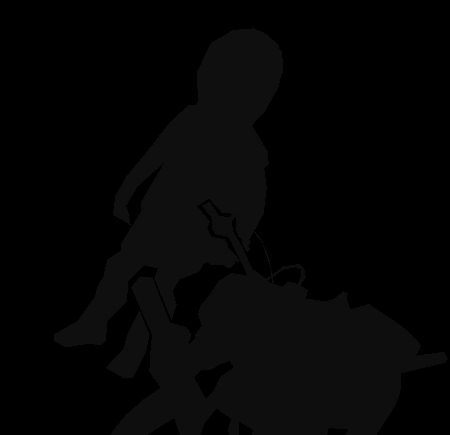

In [6]:
# display pre-encoding
from IPython.display import Image
Image(filename='../datasets/VOCdevkit/VOC2012/SegmentationClass/pre_encoded/2007_000733.png') 

### 1.5 Loss fuction and Optimizer(1.0 point)
Define below with the loss function you think would be most suitable for segmentation task. You are free to choose any optimizer to train the network.

In [7]:
from torch.optim import Adam

# loss function
# the problem is a classification problem (into 21 classes) CrossEntropyLoss works well in this case 
loss_f = nn.CrossEntropyLoss() 

# optimizer variable
# Adam contains both momentum and rmsprop feature, it works well in general
optimizer = Adam(model.parameters(), lr=lr)

### 1.6 Training the model(3.0 points)
Your task here is to complete the code below to perform a training loop and save the model weights after each epoch of training.

In [8]:
# check for gpu
if torch.cuda.is_available():
  device = torch.device('cuda:7')
else:
  device = torch.device('cpu')

# move model
model = model.to(device)

In [9]:
# save losses in lists
loss_train = []
loss_val = []

for e in range(epochs):

    # putting model in training mode
    model.train()
    total_loss = 0
    for j, (img, label) in enumerate(trainloader):
        # transfer to gpu if available for faster computation
        img, label = img.to(device), label.to(device)
        # clean previous gradients
        optimizer.zero_grad()
        # forward pass through model
        pred = model(img)
#         pred = pred['out'] # output of model is orderedDict
        # loss
        loss = loss_f(pred, label)
        total_loss += loss.item()
        # backward pass
        loss.backward()
        # gradient descent -> update parameters
        optimizer.step()
        
        if j%40 == 0:
            print("epoch{}, iter{}, loss: {}".format(e, j, total_loss/(bs*(j+1))))

    # print training loss -> later print after epoch or half epoch (costly operation)
    print(f'Epoch {e}: training loss={total_loss/len(trainloader)}')
    loss_train.append(total_loss/len(trainloader))

    # saving model weights
    torch.save(model.state_dict(), f'weights/T1/epoch_{e}.pth')

    # validation mode - batchnorm and dropout will working val mode
    model.eval()
    valid_loss = 0
    for (img, label) in validloader:
        img, label = img.to(device), label.to(device) # to gpu
        # deactivate autograd engine - reduce memory usage 
        with torch.no_grad(): 
            pred = model(img) # forward pass
#             pred = pred['out'] # output of model is orderedDict
            loss = loss_f(pred, label) # loss calc
            valid_loss += loss.item()

    print(f'Epoch {e}: validation loss={valid_loss/len(validloader)}')
    loss_val.append(valid_loss/len(validloader))


model = model.to('cpu')

epoch0, iter0, loss: 0.10198076069355011
epoch0, iter40, loss: 0.0801692144354669
Epoch 0: training loss=2.4981499728949172
Epoch 0: validation loss=3.7169298400049624
epoch1, iter0, loss: 0.051548317074775696
epoch1, iter40, loss: 0.04562692534996242
Epoch 1: training loss=1.4493255019187927
Epoch 1: validation loss=1.3220904028933982
epoch2, iter0, loss: 0.03857189416885376
epoch2, iter40, loss: 0.039302463484246555
Epoch 2: training loss=1.2477857755578083
Epoch 2: validation loss=1.2302187007406484
epoch3, iter0, loss: 0.03339065611362457
epoch3, iter40, loss: 0.038262680490932816
Epoch 3: training loss=1.2176399114339247
Epoch 3: validation loss=1.2665065578792407
epoch4, iter0, loss: 0.04453083500266075
epoch4, iter40, loss: 0.03760158761245448
Epoch 4: training loss=1.1937501508256663
Epoch 4: validation loss=1.2488240988358208


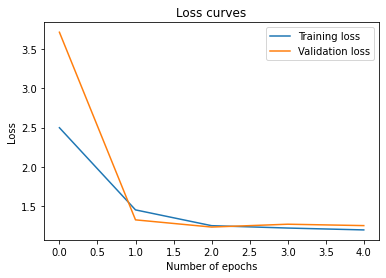

In [10]:
# Plot training and validation loss curves
X = range(epochs)
plt.plot(X, loss_train, label="Training loss")
plt.plot(X, loss_val, label="Validation loss")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Loss curves")
plt.legend() # add legend
plt.savefig('results/T1_loss_curves.png', bbox_inches='tight')
plt.show()

### 1.7 Evaluate your model(1.5 points)
In this section you have to implement the evaluation metrics for your model. Calculate the values of F1-score, dice coefficient and AUC-ROC score on the data you used for training. You can use external packages like scikit-learn to compute above metrics.

In [14]:
# import functions
from sklearn.metrics import f1_score
from utils.eval_metrics import dice_coefficient_custom, roc_auc_custom # user defined

# def evaluate(ground_truth, predictions):
#     """
#         Return evalution scores.
#     Args:   
#         ground_truth: HxW ndarray; each element contains class label from (0-20)
#         prediction: HxW ndarray; each element contains predicted class label
#     """
    
#     # calculate metrics globally (considering all false positives, true positives, false negatives and )
#     f1 = f1_score(ground_truth, predictions, average='micro') 
#     auc_score = roc_auc_score(ground_truth, predictions, average='micro', multi_class='ovr')
#     dice_coeeficient = 0

#     return f1, auc_score, dice_coeeficient

def evaluate_batch(gnd_b, pred_b):
    """
        Calculate evalution scores over the batch.
    Args:   
        gnd_b: BxHxW tensor; ground truth labels; each element of matrix in B dim contains class label from (0-20)
        pred_b: BxCxHxW tensor; each element contains predicted class label 
                here C=21 (0-20; no. of classes); each C corresponds to probabilites for that class,
                eg. C=0 contain score at each element in matrix HxW 
    Return:
        f1_score, auc_score, dice_coeeficient (averaged over batch size)
    """
    # to cpu and as numpy ndarray
    gnd_b = gnd_b.cpu().numpy()

    batch_size = gnd_b.shape[0]
    
    # extract most probable class through C-dim 
    label_b = torch.argmax(pred_b, dim=1).cpu().numpy()

    # initial value
    f1 = auc = dice = 0
    # iterate over batch elements
    for i in range(batch_size):
        gnd = gnd_b[i,:,:] 
        label = label_b[i,:,:]
        f1 += f1_score(gnd.flatten(), label.flatten(), average='micro')
        # auc += roc_auc_score(gnd.flatten(), label.flatten(), average='micro', multi_class='ovr')
        auc += roc_auc_custom(gnd, label)
        dice += dice_coefficient_custom(gnd, label)

    return [f1/batch_size, auc/batch_size, dice/batch_size]

### 1.8 Plot the evaluation metrics against epochs(1.0)
In section 1.6 we saved the weights of the model after each epoch. In this section, you have to calculate the evaluation metrics after each epoch of training by loading the weights for each epoch. Once you have calculated the evaluation metrics for each epoch, plot them against the epochs.

25.672962188720703 24.28167813592752 15.458014346146488
33.68969837824503 23.04156574421668 17.093140619231445
34.043609619140625 23.000000730353726 17.2694269359041
33.96801233291626 23.07934274992723 17.058555246557415
33.965641816457115 23.06051231271696 17.15401336102859


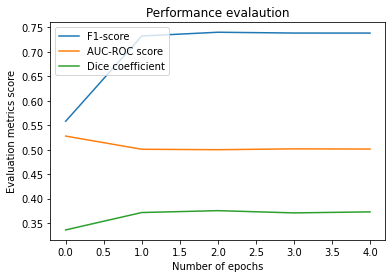

In [15]:
# list of score 
f1_list = []; auc_list = []; dice_list = []
# move model to gpu
model = model.to(device)
# loop for original number of epochs
for i in range(epochs):
    # load the model states
    model.load_state_dict(torch.load(f'weights/T1/epoch_{i}.pth'))
    # model in evaluation model -> batchnorm, dropout etc. adjusted accordingly
    model.eval()
    # evaluation score variables to store values over each epoch
    f_one = roc_auc = dice_coef = 0 

    for img, label in trainloader:
        img, label = img.to(device), label.to(device) # to gpu
        # deactivate autograd engine - reduce memory usage 
        with torch.no_grad(): 
            pred = model(img) # forward pass
            # output of model is orderedDict
#             pred = pred['out'] # Batchx21(class)xHxW
            # evaluation
            scores = evaluate_batch(label, pred)
            # sum values
            f_one += scores[0]
            roc_auc += scores[1]
            dice_coef += scores[2]
    
        # break

    print(f_one, roc_auc, dice_coef)
    # append to list (with averaged values over valid set)
    f1_list.append(f_one/len(trainloader))
    auc_list.append(roc_auc/len(trainloader))
    dice_list.append(dice_coef/len(trainloader))

# PLOT
X = range(epochs)
plt.plot(X, f1_list, label="F1-score")
plt.plot(X, auc_list, label="AUC-ROC score")
plt.plot(X, dice_list, label="Dice coefficient")
plt.xlabel("Number of epochs")
plt.ylabel("Evaluation metrics score")
plt.title("Performance evalaution")
plt.legend() # add legend
plt.savefig('results/T1_eval_metrics.png', bbox_inches='tight')
plt.show()

### 1.9 Visualize results(0.5 points)
For any 10 images in the dataset, show the images along the with their segmentation mask.

[]

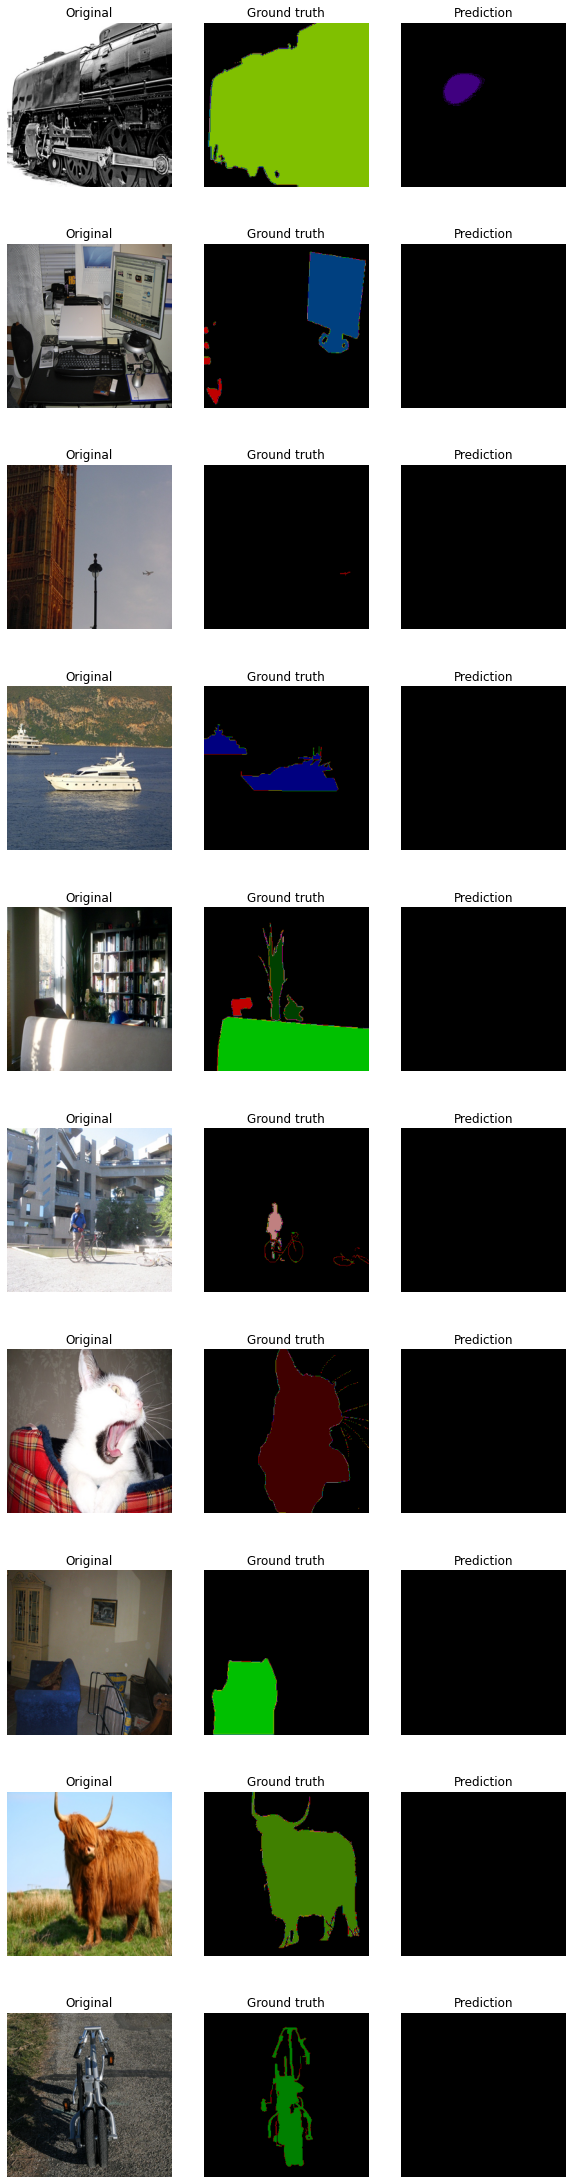

In [13]:
from utils.custom_transforms import unNormalize, decode_segmap

# move model to gpu
model = model.to(device)
# load the model states
model.load_state_dict(torch.load(f'weights/T1/epoch_{epochs-1}.pth'))
# model in evaluation model -> batchnorm, dropout etc. adjusted accordingly
model.eval()
# iterator on training data
data = iter(trainloader)
# init figure object
fig = plt.figure(figsize=(10,40))
pred_rgb = list()
# for img, label in trainloader:
for i in range(10):
    imgs, labels = next(data) # next batch
    # img, label = img.to(device).unsqueeze(0), label.to(device) # to gpu
    # using just one image
    img = imgs[0].to(device).unsqueeze(0) # to gpu
    # gnd = np.asarray(label[0]) 
    # deactivate autograd engine - reduce memory usage 
    with torch.no_grad(): 
        pred = model(img) # forward pass
        # output of model is orderedDict
#         pred = pred['out'] # 21(class)xHxW
        pred = pred.squeeze(0)
        
        # extract most probable class through C-dim 
        pred_label = torch.argmax(pred, dim=0).cpu().numpy()
        # convert labels to color code
#         pred_rgb = dst_train.decode_segmap(pred_label)
        pred_rgb = decode_segmap(pred_label)

        # plotting
        # original image
        fig.add_subplot(10, 3, 3*i+1)
        img = imgs[0].data.cpu().numpy() # data in image and current form of matrix
        img = unNormalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # unNormalize
        img = img.transpose((1,2,0)).astype(np.uint8) # change dtype to correct format for display
        plt.title('Original')
        plt.imshow(img) # original
        plt.axis('off')
        # ground truth
        fig.add_subplot(10, 3, 3*i+2)
        label = labels[0].data.numpy() # data in image and current form of matrix
        label = decode_segmap(label)
#         label = dst_train.decode_segmap(label)
        plt.title('Ground truth')
        plt.imshow(label) 
        plt.axis('off')
        # prediction
        fig.add_subplot(10, 3, 3*i+3)
        plt.title('Prediction')
        plt.imshow(pred_rgb.astype(np.uint8))
        plt.axis('off')

plt.savefig('results/T1 results.png', bbox_inches='tight')    
plt.plot()



